In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

spam_df = pd.read_csv('/sms_spam_cleaned.csv')
spam_df.head()


,label,clean_message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think goes usf lives around though


In [ ]:
spam_df.info()
print("\nShape of SMS spam: ",spam_df.shape)
spam_df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          5169 non-null   int64 
 1   clean_message  5164 non-null   object
dtypes: int64(1), object(1)
memory usage: 80.9+ KB

Shape of SMS spam:  (5169, 2)


,count
label,
0,4516
1,653


### TFIDF Vectorizer

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

spam_X = spam_df.drop('label',axis=1)
spam_y = spam_df['label']

spam_tfvector = TfidfVectorizer(analyzer='word', max_features=1000)
spam_X = spam_tfvector.fit_transform(spam_df['clean_message'].values.astype('U')).toarray()
print("Tfidf Vectorized shape of SMS spam: ",spam_X.shape)

Tfidf Vectorized shape of SMS spam:  (5169, 1000)


In [4]:
import numpy as np
np.set_printoptions(threshold=np.inf)
print(spam_X[:1]) # printing only one row

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.41976889
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.      

Splitting SMS Data

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(spam_X, spam_y, random_state=12, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=12, test_size=0.5)
print("Training SMS Samples: ", X_train.shape)
print("Validation SMS Samples: ", X_val.shape)
print("Testing SMS Samples: ", X_test.shape)

Training SMS Samples:  (3101, 1000)
Validation SMS Samples:  (1034, 1000)
Testing SMS Samples:  (1034, 1000)


### Logistic Regression

Selected Parameters for Logistic Regression:
 {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       912
           1       0.67      0.08      0.15       122

    accuracy                           0.89      1034
   macro avg       0.78      0.54      0.54      1034
weighted avg       0.86      0.89      0.85      1034



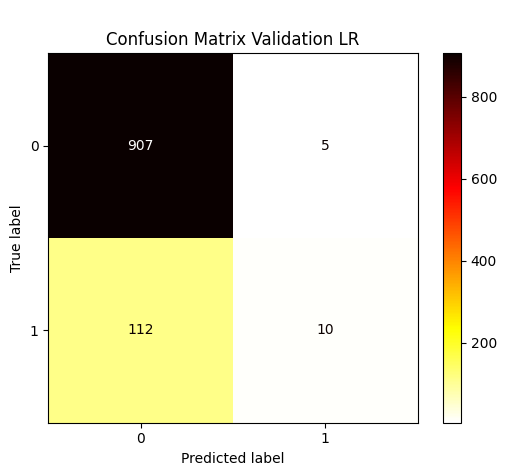

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       905
           1       0.56      0.07      0.12       129

    accuracy                           0.88      1034
   macro avg       0.72      0.53      0.53      1034
weighted avg       0.84      0.88      0.83      1034



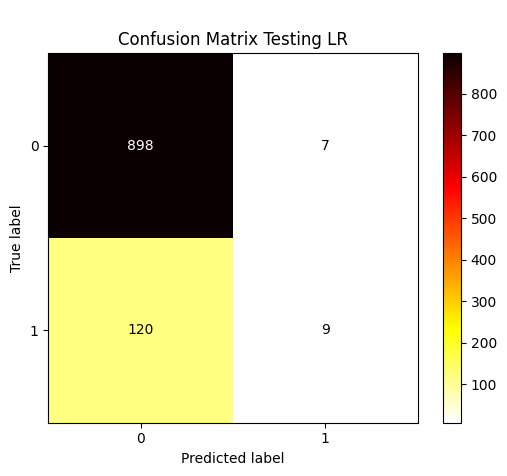

In [7]:
from sklearn.linear_model import LogisticRegression

parameters_tuning = {'penalty': ['l1', 'l2', 'elasticnet'],
                    'C': [0.1, 0.001, 0.2],
                    'solver': ['lbfgs','liblinear','sag']}

sms_model = LogisticRegression()
sms_model = GridSearchCV(sms_model, parameters_tuning, cv=2)
sms_model.fit(X_train[:700], y_train[:700])
print("Selected Parameters for Logistic Regression:\n", sms_model.best_params_)

## evaluation of training
sms_model = sms_model.best_estimator_
sms_model.fit(X_train, y_train)

## evaluation of validation
y_pred = sms_model.predict(X_val)
print(classification_report(y_val, y_pred))

cmatrix = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0, 1]).plot(cmap='hot_r')
plt.title('\nConfusion Matrix Validation LR')
plt.show()

## evaluation of testing
y_pred = sms_model.predict(X_test)
print(classification_report(y_test, y_pred))

cmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0, 1]).plot(cmap='hot_r')
plt.title('\nConfusion Matrix Testing LR')
plt.show()

### Naive Bayes

Selected Parameters for Naive Bayes:
 {'priors': None, 'var_smoothing': 1e-09}
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       912
           1       0.39      0.90      0.55       122

    accuracy                           0.82      1034
   macro avg       0.69      0.86      0.72      1034
weighted avg       0.91      0.82      0.85      1034



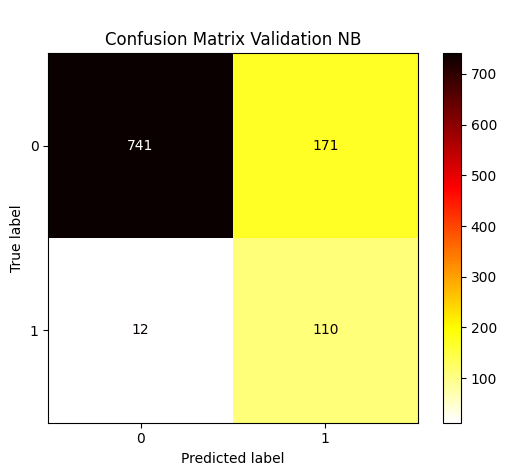

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       905
           1       0.44      0.90      0.59       129

    accuracy                           0.85      1034
   macro avg       0.71      0.87      0.75      1034
weighted avg       0.92      0.85      0.87      1034



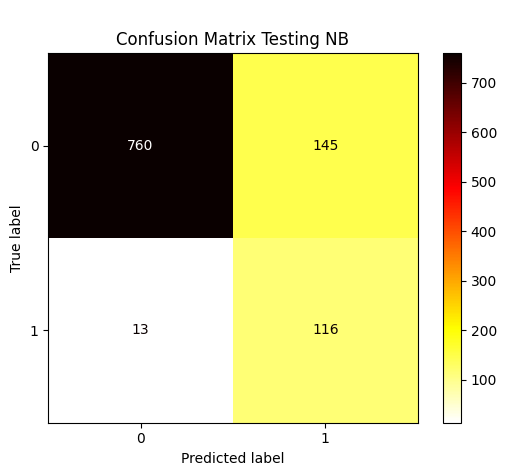

In [8]:
from sklearn.naive_bayes import GaussianNB

parameters_tuning = {'priors': [None, 0.1, 0.001, 0.05, 1.0],
                    'var_smoothing': [1e-09, 1e-06, 1e-05]}

sms_model = GaussianNB()
sms_model = GridSearchCV(sms_model, parameters_tuning, cv=2)
sms_model.fit(X_train[:700], y_train[:700])
print("Selected Parameters for Naive Bayes:\n", sms_model.best_params_)

## evaluation of training
sms_model = sms_model.best_estimator_
sms_model.fit(X_train, y_train)

## evaluation of validation
y_pred = sms_model.predict(X_val)
print(classification_report(y_val, y_pred))

cmatrix = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0, 1]).plot(cmap='hot_r')
plt.title('\nConfusion Matrix Validation NB')
plt.show()

## evaluation of testing
y_pred = sms_model.predict(X_test)
print(classification_report(y_test, y_pred))

cmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0, 1]).plot(cmap='hot_r')
plt.title('\nConfusion Matrix Testing NB')
plt.show()

### Random Forest

Selected Parameters for Random Forest:
 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       912
           1       0.93      0.78      0.85       122

    accuracy                           0.97      1034
   macro avg       0.95      0.89      0.91      1034
weighted avg       0.97      0.97      0.97      1034



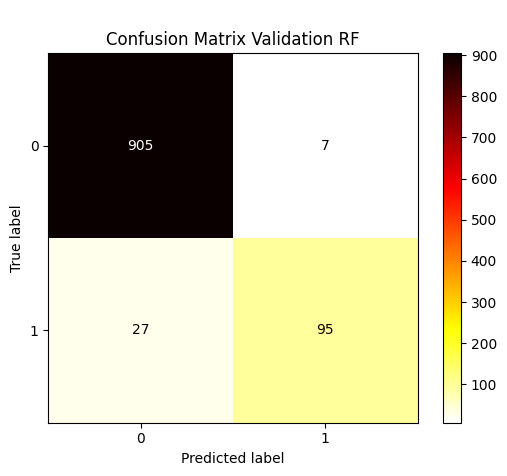

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       905
           1       0.90      0.74      0.81       129

    accuracy                           0.96      1034
   macro avg       0.93      0.86      0.89      1034
weighted avg       0.95      0.96      0.95      1034



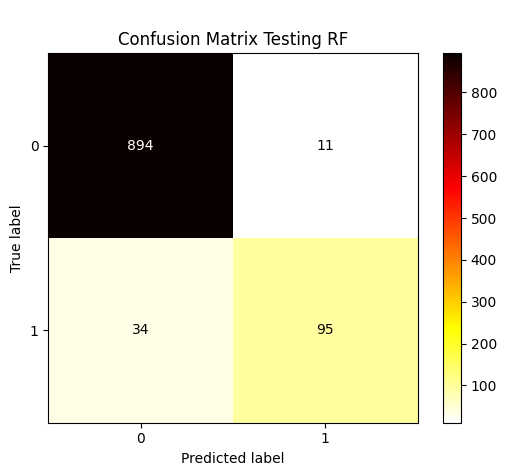

In [9]:
from sklearn.ensemble import RandomForestClassifier

parameters_tuning = {'n_estimators': [50, 10, 100, 200],
                    'criterion': ['gini', 'emtropy', 'log_loss'],
                    'max_depth': [3, 5, 10, 15],
                    'class_weight': ['balanced','balanced_subsample']}

sms_model = RandomForestClassifier()
sms_model = GridSearchCV(sms_model, parameters_tuning, cv=2)
sms_model.fit(X_train[:700], y_train[:700])
print("Selected Parameters for Random Forest:\n", sms_model.best_params_)

## evaluation of training
sms_model = sms_model.best_estimator_
sms_model.fit(X_train, y_train)

## evaluation of validation
y_pred = sms_model.predict(X_val)
print(classification_report(y_val, y_pred))

cmatrix = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0, 1]).plot(cmap='hot_r')
plt.title('\nConfusion Matrix Validation RF')
plt.show()

## evaluation of testing
y_pred = sms_model.predict(X_test)
print(classification_report(y_test, y_pred))

cmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0, 1]).plot(cmap='hot_r')
plt.title('\nConfusion Matrix Testing RF')
plt.show()

### Support Vector Machines

Selected Parameters for Support Vector Machines:
 {'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       912
           1       1.00      0.78      0.88       122

    accuracy                           0.97      1034
   macro avg       0.99      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034



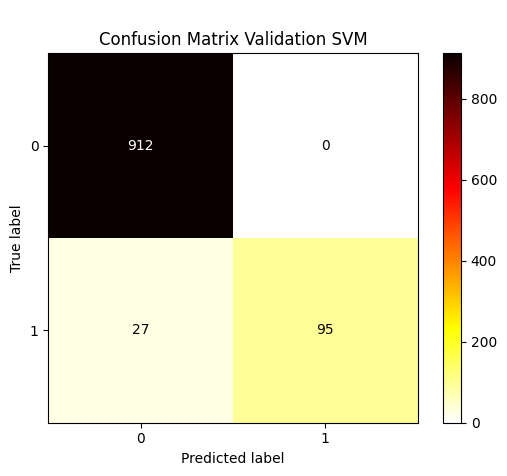

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       905
           1       0.96      0.81      0.88       129

    accuracy                           0.97      1034
   macro avg       0.97      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034



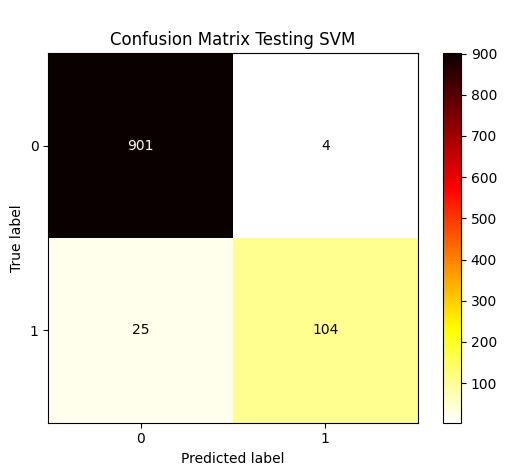

In [10]:
from sklearn.svm import SVC

parameters_tuning = {'gamma': ['scale', 'auto'],
                    'degree': [2, 5, 10, 15],
                    'kernel': ['rbf','poly','linear']}

sms_model = SVC()
sms_model = GridSearchCV(sms_model, parameters_tuning, cv=2)
sms_model.fit(X_train[:700], y_train[:700])
print("Selected Parameters for Support Vector Machines:\n", sms_model.best_params_)

## evaluation of training
sms_model = sms_model.best_estimator_
sms_model.fit(X_train, y_train)

## evaluation of validation
y_pred = sms_model.predict(X_val)
print(classification_report(y_val, y_pred))

cmatrix = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0, 1]).plot(cmap='hot_r')
plt.title('\nConfusion Matrix Validation SVM')
plt.show()

## evaluation of testing
y_pred = sms_model.predict(X_test)
print(classification_report(y_test, y_pred))

cmatrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0, 1]).plot(cmap='hot_r')
plt.title('\nConfusion Matrix Testing SVM')
plt.show()